In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import uproot, os, logging, json, random, wandb, shap
import awkward as ak
# import torch
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
from matplotlib.ticker import FormatStrFormatter
from collections import Counter

# ML model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Config
from bdt_config import sample_dict, zbi, getVarDict
from bdt_config import Vars, Vars2, Vars3, Vars_drop, Vars_plot
from bdt_config import variables, ntuple_name, ntuple_name_BDT

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font
sns.set(style="whitegrid")

# Check for gpu
# torch.cuda.is_available()

In [2]:
path = '/data/jlai/ntups/csv/jet_faking_BDT_input_basic.csv'
df = pd.read_csv(path)
df.describe()

,balance,BDTScore,dmet,dphi_jj,dphi_met_central_jet,dphi_met_phterm,dphi_met_ph,dphi_met_jetterm,dphi_phterm_jetterm,dphi_ph_centraljet1,...,metsig,metsigres,met,met_noJVT,metplusph,failJVT_jet_pt1,softerm,n_jet_central,weights,label
count,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,...,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06
mean,-1.745489e+02,1.251438e-01,-1.663472e+03,-4.661989e+02,-1.848742e+02,4.027364e-01,2.738863e+00,-1.317202e+02,-1.313245e+02,-1.842713e+02,...,1.190690e+01,2.709180e+04,1.947991e+05,1.931356e+05,8.173447e+05,8.082155e+03,9.400769e+03,1.752871e+00,6.037499e-01,1.390112e-03
std,3.835393e+02,1.348625e-01,1.103691e+04,4.983897e+02,3.894295e+02,6.314438e-01,6.313106e-01,3.400961e+02,3.402509e+02,3.897176e+02,...,1.038910e+01,2.307818e+04,1.623949e+05,1.632818e+05,8.139494e+05,1.485037e+04,5.880428e+03,1.232225e+00,7.646898e+00,3.725829e-02
min,-9.990000e+02,-3.265468e-01,-1.712589e+05,-9.990000e+02,-9.990000e+02,0.000000e+00,1.167295e-02,-9.990000e+02,-9.990000e+02,-9.990000e+02,...,2.269695e-01,8.526343e+03,1.000000e+05,2.001940e+03,1.500329e+05,-9.990000e+02,0.000000e+00,0.000000e+00,-9.143369e+01,0.000000e+00
25%,9.546858e-01,8.068899e-03,0.000000e+00,-9.990000e+02,4.369926e-02,5.094965e-02,2.728096e+00,2.204334e-01,5.477069e-01,3.878704e-01,...,3.802686e+00,1.057160e+04,1.177408e+05,1.162434e+05,2.738635e+05,-9.990000e+02,4.993511e+03,1.000000e+00,1.026595e-04,0.000000e+00
50%,1.283851e+00,1.647640e-01,0.000000e+00,-2.735425e+00,4.694079e-01,1.503438e-01,2.991172e+00,1.017702e+00,2.089735e+00,2.023582e+00,...,1.024574e+01,1.767059e+04,1.480967e+05,1.473863e+05,4.551331e+05,-9.990000e+02,8.329055e+03,2.000000e+00,1.174600e-02,0.000000e+00
75%,2.922425e+00,2.371679e-01,0.000000e+00,1.512880e-01,2.476912e+00,4.133940e-01,3.090613e+00,2.863652e+00,3.105098e+00,3.039348e+00,...,1.590387e+01,3.643209e+04,2.160463e+05,2.158321e+05,1.013744e+06,2.159741e+04,1.265224e+04,3.000000e+00,5.386639e-02,0.000000e+00
max,2.663229e+02,4.375860e-01,1.246841e+05,3.141591e+00,3.141592e+00,3.141593e+00,3.141593e+00,3.141593e+00,3.141593e+00,3.141592e+00,...,2.823775e+02,6.173285e+06,1.470684e+08,1.470684e+08,1.490961e+08,5.999986e+04,1.022158e+05,4.000000e+00,1.221239e+04,1.000000e+00


Number of event with negative weights : 218306


,balance,BDTScore,dmet,dphi_jj,dphi_met_central_jet,dphi_met_phterm,dphi_phterm_jetterm,ph_phi,jet_central_eta,jet_central_pt2,...,metsig,metsigres,met_noJVT,softerm,n_jet_central,weights,label,failJVT_jet_pt1,ph_eta,ph_pt
count,2.712769e+06,3.299733e+06,3.299732e+06,1.759863e+06,2.685312e+06,3.299733e+06,2.859950e+06,3.299733e+06,2.712769e+06,1.759863e+06,...,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,977687.000000,3.299733e+06,3.299733e+06
mean,3.838187e+00,1.251438e-01,-1.663472e+03,-1.055280e-03,1.404322e+00,4.027364e-01,2.100537e+00,-2.322857e-03,1.122273e-03,1.301373e+05,...,1.190690e+01,2.709180e+04,1.931356e+05,9.400769e+03,1.752871e+00,6.196378e-01,1.390112e-03,0.000036,4.619389e+00,5.638744e-06
std,6.130255e+00,1.348625e-01,1.103691e+04,1.698739e+00,1.176454e+00,6.314438e-01,1.085866e+00,1.819052e+00,1.077024e+00,1.853047e+05,...,1.038910e+01,2.307818e+04,1.632818e+05,5.880428e+03,1.232225e+00,7.645627e+00,3.725829e-02,0.000009,4.657088e+02,4.934680e-06
min,3.173358e-02,-3.265468e-01,-1.712589e+05,-3.141591e+00,1.192093e-07,0.000000e+00,0.000000e+00,-3.141592e+00,-2.499994e+00,2.000003e+04,...,2.269695e-01,8.526343e+03,2.001940e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000017,3.966429e-01,1.995369e-07
25%,1.127429e+00,8.068899e-03,0.000000e+00,-1.266605e+00,1.804473e-01,5.094965e-02,1.077754e+00,-1.578759e+00,-7.428238e-01,3.167094e+04,...,3.802686e+00,1.057160e+04,1.162434e+05,4.993511e+03,1.000000e+00,1.428430e-03,0.000000e+00,0.000030,7.511125e-01,1.213521e-06
50%,1.535997e+00,1.647640e-01,0.000000e+00,-7.278919e-04,1.257375e+00,1.503438e-01,2.536042e+00,-6.129133e-03,-1.606467e-03,6.061452e+04,...,1.024574e+01,1.767059e+04,1.473863e+05,8.329055e+03,2.000000e+00,1.519263e-02,0.000000e+00,0.000038,1.271312e+00,4.487454e-06
75%,3.771265e+00,2.371679e-01,0.000000e+00,1.260984e+00,2.651747e+00,4.133940e-01,3.115461e+00,1.571243e+00,7.461343e-01,1.416852e+05,...,1.590387e+01,3.643209e+04,2.158321e+05,1.265224e+04,3.000000e+00,6.219316e-02,0.000000e+00,0.000044,2.644231e+00,8.563076e-06
max,2.663229e+02,4.375860e-01,1.246841e+05,3.141591e+00,3.141592e+00,3.141593e+00,3.141593e+00,3.141584e+00,2.499999e+00,3.397636e+06,...,2.823775e+02,6.173285e+06,1.470684e+08,1.022158e+05,4.000000e+00,1.221239e+04,1.000000e+00,0.000050,8.314374e+05,1.999992e-05


Number of nan in each variable: 
balance                  586964
BDTScore                      0
dmet                          1
dphi_jj                 1539870
dphi_met_central_jet     614421
dphi_met_phterm               0
dphi_phterm_jetterm      439783
ph_phi                        0
jet_central_eta          586964
jet_central_pt2         1539870
jetterm                       0
metsig                        0
metsigres                     0
met_noJVT                     0
softerm                       0
n_jet_central                 0
weights                       0
label                         0
process                       0
failJVT_jet_pt1         2322046
ph_eta                        0
ph_pt                         0
dtype: int64
random number:  21


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dlai211 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Best parameters found: {'gamma': 0.38149047087423726, 'learning_rate': 0.07137359234237312, 'max_depth': 9, 'n_estimators': 403, 'subsample': 0.919477983027197}


[16:34:49] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



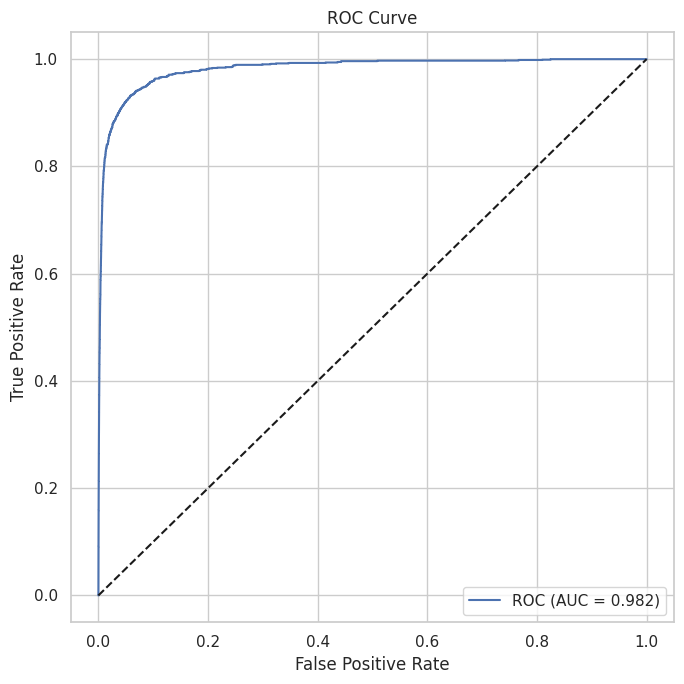

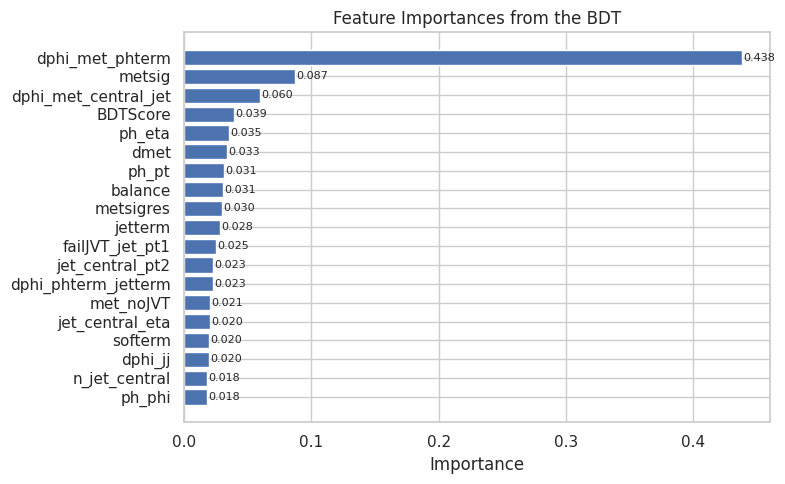

Best CV neg_log_loss,▁
Test Accuracy,▁
Test LogLoss,▁
Test ROC AUC,▁
Train Accuracy,▁
Train LogLoss,▁
Train ROC AUC,▁
iteration,▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
test_auc,▁▁▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████████████████████
test_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
test_logloss,█▇▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [3]:
# === Data Perparation ===
df_Vars2 = df[Vars2].copy()
df_Vars3 = df[Vars3].copy()

df_Vars3.replace(-999, np.nan, inplace=True)
df_Vars3_inverted = 1 / df_Vars3.replace({0: np.nan})  # Avoid division by zero

df_ml_input = pd.concat([df_Vars2, df_Vars3_inverted], axis=1)
df_ml_input.replace(-999, np.nan, inplace=True)
print("Number of event with negative weights :", np.sum(df_ml_input.weights < 0))
df_ml_input["weights"] = df_ml_input["weights"].abs() # some of the weights are negative

display(df_ml_input.describe())

print("Number of nan in each variable: ")
print(df_ml_input.isna().sum())

# Define X (features) and y (labels)
# Vars_drop = ['weights', 'label', 'process']
X = df_ml_input.drop(Vars_drop, axis=1)
y = df_ml_input['label']
weights = df_ml_input['weights']

''' This will disrupt the bdtscore2
# === Standardize the Data (Optional) ===
scaler = StandardScaler()
X = scaler.fit_transform(X)
'''

# # Reweight signal so that total signal weight = total background weight
# sig_mask = df_ml_input['label'] == 1
# bkg_mask = df_ml_input['label'] == 0

# sum_sig = df_ml_input.loc[sig_mask, 'weights'].sum()
# sum_bkg = df_ml_input.loc[bkg_mask, 'weights'].sum()

# scale_factor = sum_bkg / sum_sig if sum_sig > 0 else 1.0
# df_ml_input.loc[sig_mask, 'weights'] *= scale_factor

random_num = random.randint(1, 100)
print("random number: ", random_num)

X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, weights, test_size=0.3, random_state=random_num, stratify=y)

wandb.init(project="Dark_ph BDT Random", reinit=True, resume=False)

param_distributions = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.0001, 0.1),
    'n_estimators': randint(100, 900),
    'subsample': uniform(0.8, 0.2),
    'gamma': uniform(0.1, 1),               # higher = more pruning
}

xgb_clf = XGBClassifier(
    tree_method='hist',
    device='cuda',
    eval_metric=['logloss', 'error', 'auc'],
    early_stopping_rounds=10,
    missing=np.nan,  # Let XGBoost handle any remaining NaNs
    random_state=random_num
)

random_search = RandomizedSearchCV(
    xgb_clf, param_distributions, n_iter=20, scoring='roc_auc', refit=True,
    cv=5, n_jobs=-1, random_state=random_num
)

random_search.fit(X_train, y_train,
          sample_weight=sw_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          sample_weight_eval_set=[sw_train, sw_test],
          verbose=False)

best_model = random_search.best_estimator_
wandb.config.update(random_search.best_params_)
wandb.log({"Best CV neg_log_loss": random_search.best_score_})
print("Best parameters found:", random_search.best_params_)

# Generate BDT score predictions for all data
df_ml_input["bdtscore2"] = best_model.predict_proba(df_ml_input.drop(Vars_drop, axis=1))[:, 1]

results = best_model.evals_result()
train_loss = results['validation_0']['logloss']
test_loss = results['validation_1']['logloss']
train_error = results['validation_0']['error']
test_error = results['validation_1']['error']
train_auc = results['validation_0']['auc']
test_auc = results['validation_1']['auc']

for i, (train_l, test_l, train_e, test_e, train_a, test_a) in enumerate(zip(train_loss, test_loss, train_error, test_error, train_auc, test_auc)):
    wandb.log({
        "train_logloss": train_l,
        "test_logloss": test_l,
        "train_error": train_e,
        "test_error": test_e,
        "train_auc": train_a,
        "test_auc": test_a,
        "iteration": i
    })

y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

metrics = {
    "Train LogLoss": log_loss(y_train, y_train_pred_proba, sample_weight=sw_train),
    "Test LogLoss": log_loss(y_test, y_test_pred_proba, sample_weight=sw_test),
    "Train Accuracy": accuracy_score(y_train, y_train_pred),
    "Test Accuracy": accuracy_score(y_test, y_test_pred),
    "Train ROC AUC": roc_auc_score(y_train, y_train_pred_proba, sample_weight=sw_train),
    "Test ROC AUC": roc_auc_score(y_test, y_test_pred_proba, sample_weight=sw_test)
}

wandb.log(metrics)

fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba, sample_weight=sw_test)
tpr_sel = 217.13/374.83
fpr_sel = 5066.37/227609.78
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label="ROC (AUC = {:.3f})".format(metrics["Test ROC AUC"]))
# plt.scatter(fpr_sel, tpr_sel, color='orange', label='cut-flow point')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("roc_randomsearch.png")
wandb.log({"ROC Curve": wandb.Image("roc_randomsearch.png")})
plt.show()

importances = best_model.feature_importances_
indices = np.argsort(importances)
selected_columns = df_ml_input.drop(Vars_drop + ['bdtscore2'], axis=1).columns

plt.figure(figsize=(8, 5))
bars = plt.barh(range(len(selected_columns)), importances[indices], align='center')

# Set y-ticks with feature names
plt.yticks(range(len(selected_columns)), [selected_columns[i] for i in indices])
plt.xlabel('Importance')
plt.title('Feature Importances from the BDT')

# Annotate each bar with the importance value
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center', fontsize=8)
plt.tight_layout()
plt.savefig("feature_importance.png")
wandb.log({"Feature Importance": wandb.Image("feature_importance.png")})
plt.show()


wandb.finish()

In [8]:
best_iteration = best_model.best_iteration
print("Best iteration used:", best_iteration)

Best iteration used: 207


/home/jlai/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:44:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [4]:
%%time
X_no_drop = df_ml_input.drop(Vars_drop + ['bdtscore2'], axis=1)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_no_drop)

CPU times: user 43.1 s, sys: 389 ms, total: 43.5 s
Wall time: 42.6 s


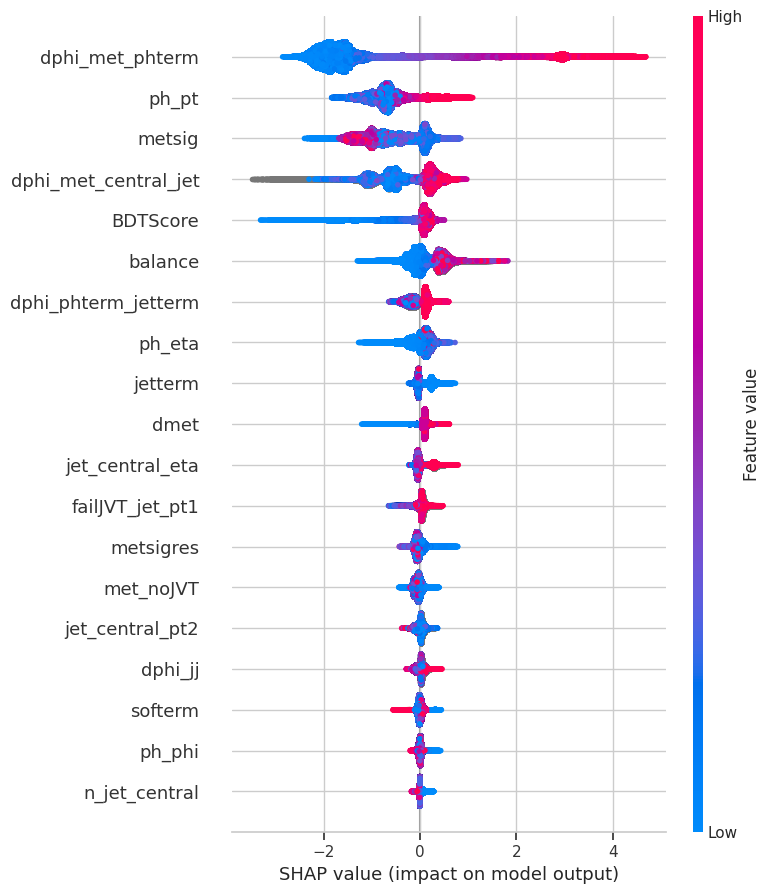

In [12]:

shap.summary_plot(shap_values, X_no_drop, show=False)
plt.tight_layout()
plt.show()

# top_var = X_no_drop.columns[np.abs(shap_values.values).mean(axis=0).argmax()]
# shap.dependence_plot(top_var, shap_values.values, X_no_drop, show=False)
# plt.tight_layout()
# plt.show()


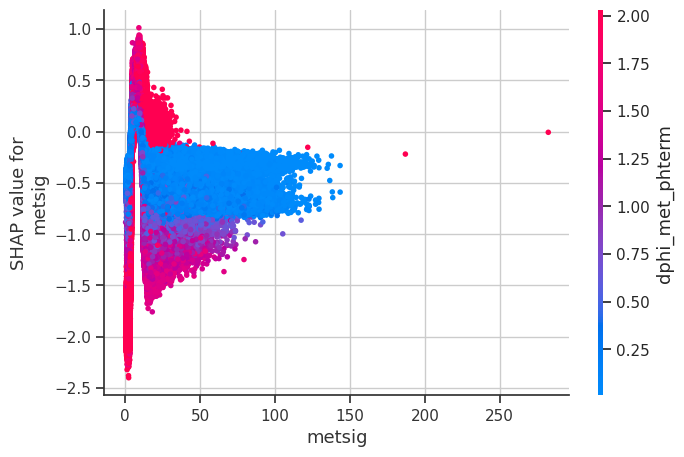

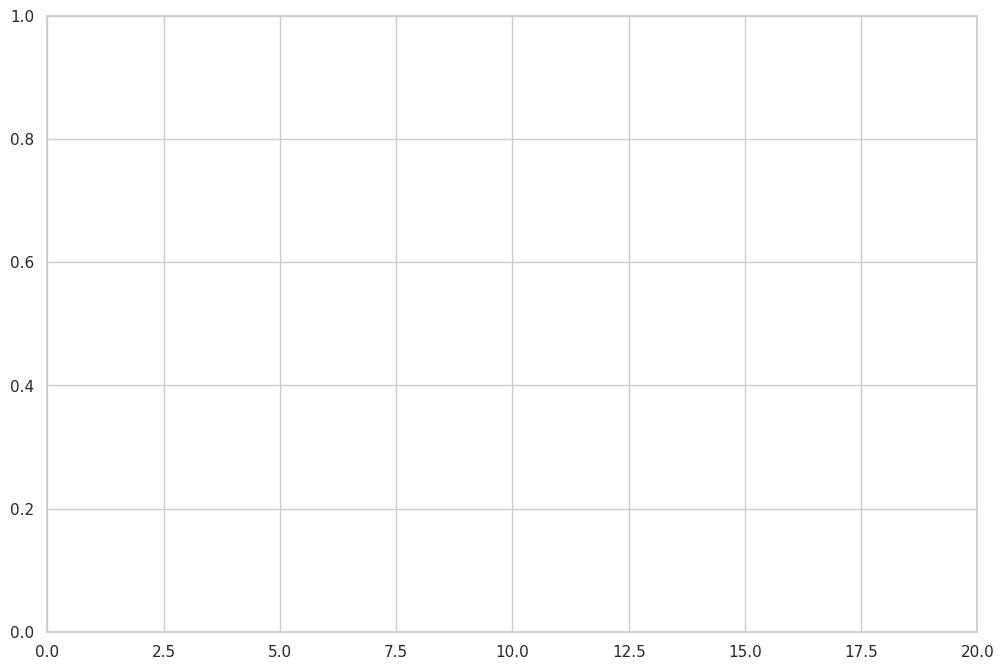

In [9]:
var_name_tmp = 'metsig'
shap.dependence_plot(var_name_tmp, shap_values.values, X)
plt.xlim(0, 20)
plt.savefig('shap_plots/'+var_name_tmp)

# Need to do a feature vs. BDTScore2 2d scatter plot

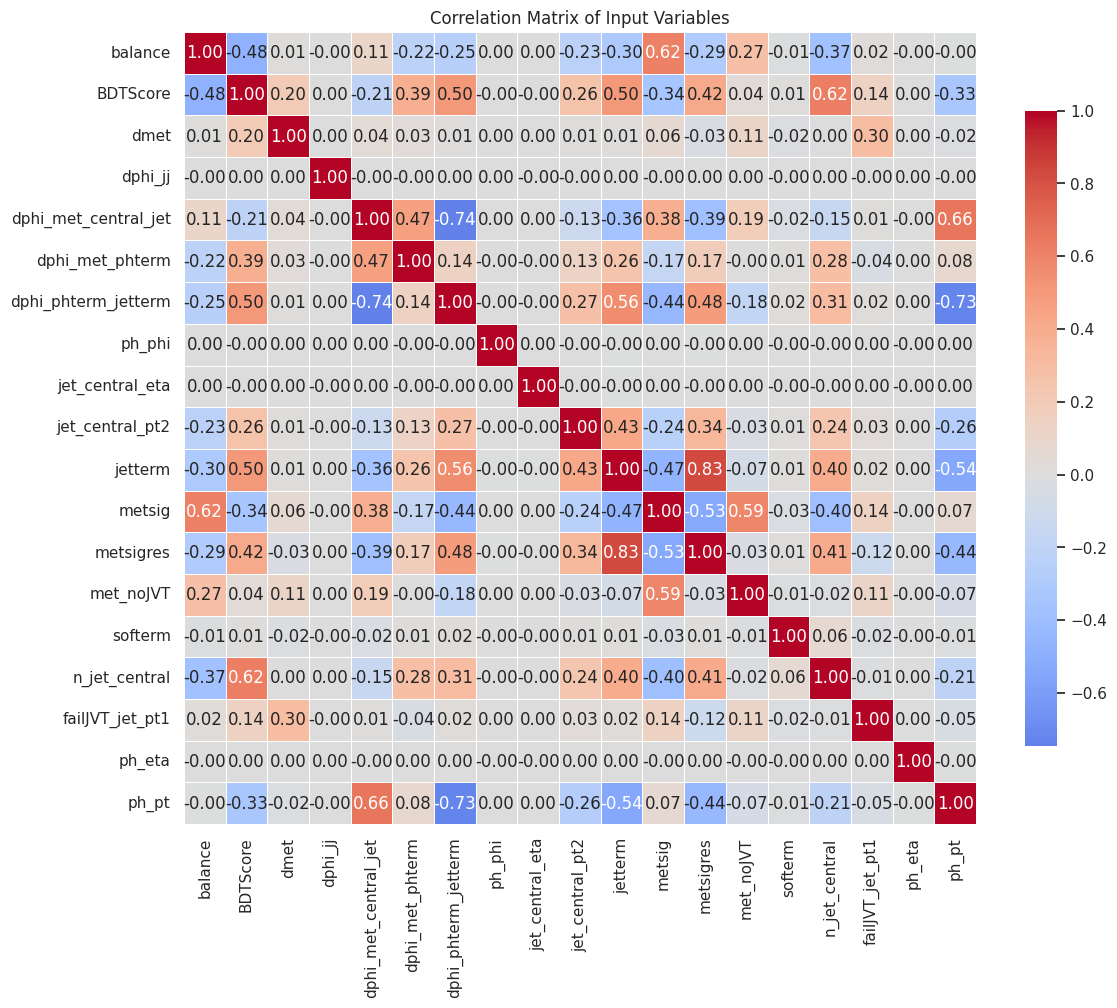

In [20]:
corr_features = df_ml_input.drop(Vars_drop + ['bdtscore2'], axis=1)
corr_matrix = corr_features.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Input Variables")
plt.tight_layout()
plt.savefig("correlation_matrix.png")
plt.show()


Saved plot to significance_bdtscore2_lowercut.png


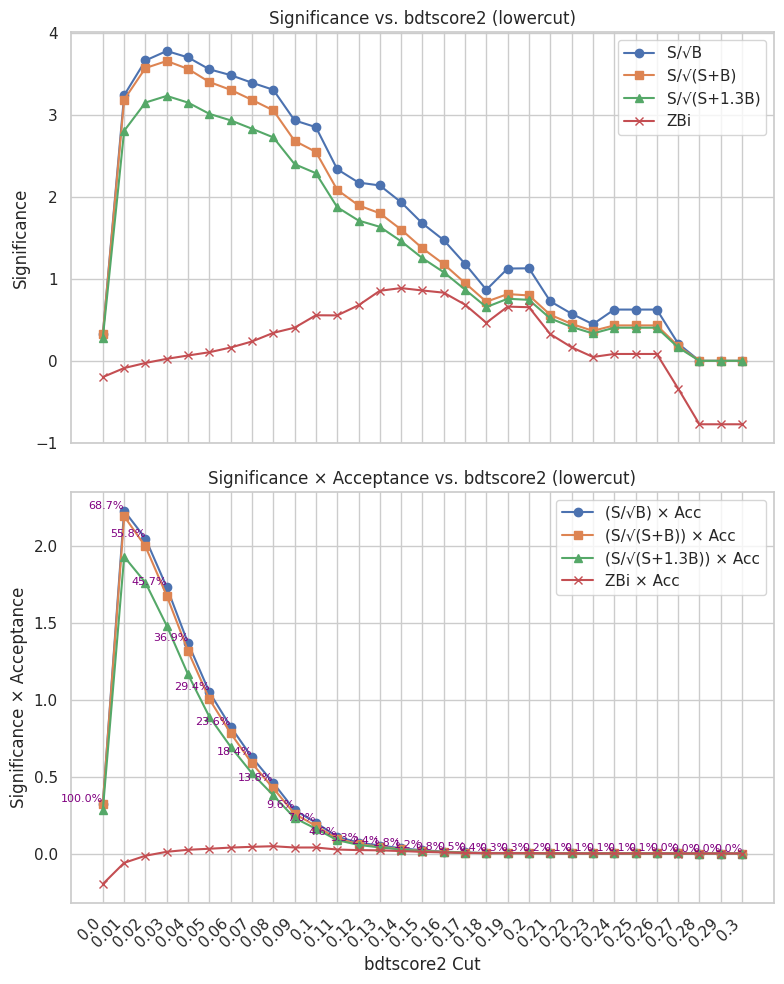

In [15]:
def binomial_significance(s, b):
    return s / np.sqrt(b) if b > 0 else 0

def s_over_sb(s, b):
    return s / np.sqrt(s + b) if (s + b) > 0 else 0

def s_over_s1p3b(s, b):
    return s / np.sqrt(s + 1.3 * b) if (s + 1.3 * b) > 0 else 0

def scan_significance(df, cut_var="bdtscore2", cut_type="lowercut", cuts=np.arange(0, 0.71, 0.01)):
    sig_sqrtb = []
    sig_sqrt_sb = []
    sig_sqrt_s1p3b = []
    sig_zbi = []

    sigacc_sqrtb = []
    sigacc_sqrt_sb = []
    sigacc_sqrt_s1p3b = []
    sigacc_zbi = []

    acc_values = []

    df_sig = df[df["label"] == 1]
    df_bkg = df[df["label"] == 0]
    total_sig_weight = df_sig["weights"].sum()

    for cut in cuts:
        if cut_type == "lowercut":
            sig_cut = df_sig[df_sig[cut_var] >= cut]
            bkg_cut = df_bkg[df_bkg[cut_var] >= cut]
        elif cut_type == "uppercut":
            sig_cut = df_sig[df_sig[cut_var] <= cut]
            bkg_cut = df_bkg[df_bkg[cut_var] <= cut]
        else:
            raise ValueError("Invalid cut type")

        s = sig_cut["weights"].sum()
        b = bkg_cut["weights"].sum()
        acceptance = s / total_sig_weight if total_sig_weight > 0 else 0

        # Compute significance
        sig1 = binomial_significance(s, b)
        sig2 = s_over_sb(s, b)
        sig3 = s_over_s1p3b(s, b)
        sig4 = zbi(s, b)

        sig_sqrtb.append(sig1)
        sig_sqrt_sb.append(sig2)
        sig_sqrt_s1p3b.append(sig3)
        sig_zbi.append(sig4)

        sigacc_sqrtb.append(sig1 * acceptance)
        sigacc_sqrt_sb.append(sig2 * acceptance)
        sigacc_sqrt_s1p3b.append(sig3 * acceptance)
        sigacc_zbi.append(sig4 * acceptance)

        acc_values.append(acceptance * 100)

    return cuts, acc_values, sig_sqrtb, sig_sqrt_sb, sig_sqrt_s1p3b, sig_zbi, \
           sigacc_sqrtb, sigacc_sqrt_sb, sigacc_sqrt_s1p3b, sigacc_zbi


def plot_significance(cuts, acc, sig1, sig2, sig3, sig4,
                      sigacc1, sigacc2, sigacc3, sigacc4,
                      cut_var, cut_type, save_path):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

    # Plot Significance
    ax1.plot(cuts, sig1, marker='o', label='S/√B')
    ax1.plot(cuts, sig2, marker='s', label='S/√(S+B)')
    ax1.plot(cuts, sig3, marker='^', label='S/√(S+1.3B)')
    ax1.plot(cuts, sig4, marker='x', label='ZBi')

    ax1.set_ylabel('Significance')
    ax1.set_title(f'Significance vs. {cut_var} ({cut_type})')
    ax1.grid(True)
    ax1.legend()

    # Plot Significance × Acceptance
    ax2.plot(cuts, sigacc1, marker='o', label='(S/√B) × Acc')
    ax2.plot(cuts, sigacc2, marker='s', label='(S/√(S+B)) × Acc')
    ax2.plot(cuts, sigacc3, marker='^', label='(S/√(S+1.3B)) × Acc')
    ax2.plot(cuts, sigacc4, marker='x', label='ZBi × Acc')

    for i, txt in enumerate(acc):
        ax2.text(cuts[i], sigacc1[i], f'{txt:.1f}%', fontsize=8, color='purple', ha='right', va='bottom')

    ax2.set_xlabel(f'{cut_var} Cut')
    ax2.set_ylabel('Significance × Acceptance')
    ax2.set_title(f'Significance × Acceptance vs. {cut_var} ({cut_type})')
    ax2.grid(True)
    ax2.legend()
    ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_xticks(cuts)
    ax2.set_xticklabels(cuts, rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Saved plot to {save_path}")
    plt.show()


cut_var = "bdtscore2"
cut_type = "lowercut"
cut_values = np.arange(0, 0.31, 0.01)

(cuts, acc, sig1, sig2, sig3, sig4,
 sigacc1, sigacc2, sigacc3, sigacc4) = scan_significance(df_ml_input, cut_var, cut_type, cut_values)

plot_significance(
    cuts, acc, sig1, sig2, sig3, sig4,
    sigacc1, sigacc2, sigacc3, sigacc4,
    cut_var=cut_var,
    cut_type=cut_type,
    save_path=f"significance_{cut_var}_{cut_type}.png"
)


In [16]:
bdtscore2_cut = 0.03
signal_bdtscore2_cut = df_ml_input[(df_ml_input.label==1) & (df_ml_input.bdtscore2 >= bdtscore2_cut)]['weights'].sum()
bkg_bdtscore2_cut = df_ml_input[(df_ml_input.label==0) & (df_ml_input.bdtscore2 >= bdtscore2_cut)]['weights'].sum()
signal_bdtscore2_cut / np.sqrt(bkg_bdtscore2_cut)

3.7834598182820587

In [22]:
from collections import Counter
df_origin = df.copy()
df_origin["bdtscore2"] = best_model.predict_proba(df_ml_input.drop(Vars_drop + ['bdtscore2'], axis=1))[:, 1]
ntuple_names = list(Counter(df.process).keys())
corr_features = df_origin.drop(Vars_drop + ['bdtscore2'], axis=1)
ntuple_names, corr_features.columns

(['ggHyyd', 'Zjets', 'Zgamma', 'Wgamma', 'Wjets', 'gammajet_direct', 'data23'],
 Index(['balance', 'BDTScore', 'dmet', 'dphi_jj', 'dphi_met_central_jet',
        'dphi_met_phterm', 'dphi_met_ph', 'dphi_met_jetterm',
        'dphi_phterm_jetterm', 'dphi_ph_centraljet1', 'ph_pt', 'ph_eta',
        'ph_phi', 'jet_central_eta', 'jet_central_pt1', 'jet_central_pt2',
        'jetterm', 'jetterm_sumet', 'metsig', 'metsigres', 'met', 'met_noJVT',
        'metplusph', 'failJVT_jet_pt1', 'softerm', 'n_jet_central'],
       dtype='object'))

In [23]:
df_origin

,balance,BDTScore,dmet,dphi_jj,dphi_met_central_jet,dphi_met_phterm,dphi_met_ph,dphi_met_jetterm,dphi_phterm_jetterm,dphi_ph_centraljet1,...,met,met_noJVT,metplusph,failJVT_jet_pt1,softerm,n_jet_central,weights,process,label,bdtscore2
0,3.382770,0.131412,0.000,-999.000000,1.307934,0.938348,2.203245,0.664073,1.602420,2.772006,...,106920.875,106920.875,171646.17,21859.162109,1942.6106,1,0.074079,ggHyyd,1,1.315211e-03
1,1.784722,0.151073,0.000,-999.000000,2.712346,1.180506,1.961087,0.429247,1.609753,1.609753,...,102183.560,102183.560,154814.61,-999.000000,12993.3780,1,0.116076,ggHyyd,1,7.429536e-02
2,1.122666,0.326790,0.000,-0.313718,2.255124,1.881112,1.260481,0.642131,2.523243,2.767581,...,113106.060,113106.060,235372.84,-999.000000,4500.8604,3,0.119337,ggHyyd,1,3.497988e-02
3,0.756231,0.267467,0.000,-2.166679,2.601409,1.852292,1.289300,0.349927,2.202219,2.392476,...,131013.914,131013.914,197134.22,33962.769531,16936.4980,3,0.115276,ggHyyd,1,1.985227e-03
4,1.266329,0.189026,0.000,-2.670413,1.626958,0.323595,2.817997,0.546473,0.870069,1.838230,...,125378.336,125378.336,213597.25,-999.000000,2516.5588,2,0.119649,ggHyyd,1,1.515771e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299728,7.581804,0.021344,20045.516,-999.000000,-999.000000,0.086615,3.054977,0.144932,0.231547,-999.000000,...,136645.890,156691.400,207548.94,25537.773438,8009.5220,1,11.211798,data23,0,1.651826e-05
3299729,4.419554,-0.046651,-23196.453,-999.000000,-999.000000,0.132232,3.009361,0.261050,0.393281,-999.000000,...,148601.120,125404.670,225048.72,23714.308594,9464.1780,1,11.578539,data23,0,1.614218e-06
3299730,2.965068,0.218955,0.000,-999.000000,-999.000000,0.190657,2.950936,0.153479,0.344136,-999.000000,...,388933.000,388933.000,544819.90,-999.000000,20142.2170,1,10.425924,data23,0,5.785725e-07
3299731,4.414888,-0.055574,0.000,2.633032,2.473053,0.179639,2.961954,2.039606,2.219245,0.488901,...,100550.080,100550.080,209262.25,-999.000000,3081.4370,2,11.578539,data23,0,1.863448e-05


In [24]:
for cut_var_tmp in corr_features.columns:
    print(f"'mc23d_basiccut/{cut_var_tmp}_nodijet.png',")
    print(f"'mc23d_dphi_jjcut/{cut_var_tmp}_nodijet.png',")
    print(f"'mc23d_mlcut/{cut_var_tmp}_nodijet.png',")

'mc23d_basiccut/balance_nodijet.png',
'mc23d_dphi_jjcut/balance_nodijet.png',
'mc23d_mlcut/balance_nodijet.png',
'mc23d_basiccut/BDTScore_nodijet.png',
'mc23d_dphi_jjcut/BDTScore_nodijet.png',
'mc23d_mlcut/BDTScore_nodijet.png',
'mc23d_basiccut/dmet_nodijet.png',
'mc23d_dphi_jjcut/dmet_nodijet.png',
'mc23d_mlcut/dmet_nodijet.png',
'mc23d_basiccut/dphi_jj_nodijet.png',
'mc23d_dphi_jjcut/dphi_jj_nodijet.png',
'mc23d_mlcut/dphi_jj_nodijet.png',
'mc23d_basiccut/dphi_met_central_jet_nodijet.png',
'mc23d_dphi_jjcut/dphi_met_central_jet_nodijet.png',
'mc23d_mlcut/dphi_met_central_jet_nodijet.png',
'mc23d_basiccut/dphi_met_phterm_nodijet.png',
'mc23d_dphi_jjcut/dphi_met_phterm_nodijet.png',
'mc23d_mlcut/dphi_met_phterm_nodijet.png',
'mc23d_basiccut/dphi_met_ph_nodijet.png',
'mc23d_dphi_jjcut/dphi_met_ph_nodijet.png',
'mc23d_mlcut/dphi_met_ph_nodijet.png',
'mc23d_basiccut/dphi_met_jetterm_nodijet.png',
'mc23d_dphi_jjcut/dphi_met_jetterm_nodijet.png',
'mc23d_mlcut/dphi_met_jetterm_nodijet.png',


In [24]:
signal_name = 'ggHyyd'  # Define signal dataset
cut_name = 'ml'

for cut_var_tmp in corr_features.columns:
    var_config = getVarDict(signal_name, 'ggHyyd', var_name=cut_var_tmp)
    
    for var in var_config:
        # print(var)
        bg_values = []     
        bg_weights = []    
        bg_colors = []     
        bg_labels = []     
    
        signal_values = [] 
        signal_weights = []
        signal_color = None 
        signal_label = None
    
        for j in range(len(ntuple_names)):
            process = ntuple_names[j]
            df_tmp = df_origin[df_origin.process == process]
            df_tmp = df_tmp.replace(np.nan, -999)
            df_tmp = df_tmp[df_tmp.bdtscore2 > 0.03]
            
            x = df_tmp[var]
            bins = var_config[var]['bins'] 
            weights = df_tmp['weights']
            
            sample_info = sample_dict[process]
            color = sample_info['color']
            legend = sample_info['legend']
    
            
            if process == 'ggHyyd':  # signal
                signal_values.append(x)
                signal_weights.append(weights)
                signal_color = color
                signal_label = legend
            else:   # background
                bg_values.append(x)
                bg_weights.append(weights)
                bg_colors.append(color)
                bg_labels.append(legend)
    
        fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(12, 13), gridspec_kw={'height_ratios': [9, 4]})
    
        ax_top.hist(bg_values, bins=bins, weights=bg_weights, color=bg_colors,
                    label=bg_labels, stacked=True)
    
        ax_top.hist(signal_values, bins=bins, weights=signal_weights, color=signal_color,
                    label=signal_label, histtype='step', linewidth=2)
    
        signal_all = np.concatenate(signal_values) if len(signal_values) > 0 else np.array([])
        signal_weights_all = np.concatenate(signal_weights) if len(signal_weights) > 0 else np.array([])
    
        # Add error bar for signal (top plot)
        if len(signal_all) > 0:
            signal_counts, bin_edges = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
            sum_weights_sq, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all**2)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            signal_errors = np.sqrt(sum_weights_sq)  # Poisson error sqrt(N)
    
            ax_top.errorbar(bin_centers, signal_counts, yerr=signal_errors, fmt='.', linewidth=2,
                            color=signal_color, capsize=0)
    
        ax_top.set_yscale('log')
        ax_top.set_ylim(0.0001, 1e11)
        ax_top.set_xlim(bins[0], bins[-1])
        ax_top.minorticks_on()
        ax_top.grid(True, which="both", linestyle="--", linewidth=0.5)
        ax_top.set_ylabel("Events")
        ax_top.legend(ncol=2)
        # ax_top.set_title("vtx_sumPt distribution")
    
        bg_all = np.concatenate(bg_values) if len(bg_values) > 0 else np.array([])
        bg_weights_all = np.concatenate(bg_weights) if len(bg_weights) > 0 else np.array([])
    
        # Compute the weighted histogram counts using np.histogram
        S_counts, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
        B_counts, _ = np.histogram(bg_all, bins=bins, weights=bg_weights_all)     
    
        # Compute per-bin significance
        sig_simple = np.zeros_like(S_counts, dtype=float)
        sig_s_plus_b = np.zeros_like(S_counts, dtype=float)
        sig_s_plus_1p3b = np.zeros_like(S_counts, dtype=float)
    
        sqrt_B = np.sqrt(B_counts)
        sqrt_SplusB = np.sqrt(S_counts + B_counts)
        sqrt_Splus1p3B = np.sqrt(S_counts + 1.3 * B_counts)
    
        # Avoid division by zero safely
        sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
        sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
        sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)
    
        # Add Binomial ExpZ per bin
        zbi_per_bin = np.array([
            zbi(S_counts[i], B_counts[i], sigma_b_frac=0.3)
            for i in range(len(S_counts))
        ])
    
        # Compute the bin centers for plotting
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
        # Compute the total significance: total S / sqrt(total B)
        total_signal = np.sum(S_counts)
        total_bkg = np.sum(B_counts)
    
        if total_bkg > 0:
            total_sig_simple = total_signal / np.sqrt(total_bkg)
            total_sig_s_plus_b = total_signal / np.sqrt(total_signal + total_bkg)
            total_sig_s_plus_1p3b = total_signal / np.sqrt(total_signal + 1.3 * total_bkg)
            total_sig_binomial = zbi(total_signal, total_bkg, sigma_b_frac=0.3)
        else:
            total_sig_simple = total_sig_s_plus_b = total_sig_s_plus_1p3b = total_sig_binomial = 0
    
        # --- Plot all significance curves ---
        ax_bot.step(bin_centers, sig_simple, where='mid', color='chocolate', linewidth=2,
                    label=f"S/√B = {total_sig_simple:.4f}")
        ax_bot.step(bin_centers, sig_s_plus_b, where='mid', color='tomato', linewidth=2,
                    label=f"S/√(S+B) = {total_sig_s_plus_b:.4f}")
        ax_bot.step(bin_centers, sig_s_plus_1p3b, where='mid', color='orange', linewidth=2,
                    label=f"S/√(S+1.3B) = {total_sig_s_plus_1p3b:.4f}")
        ax_bot.step(bin_centers, zbi_per_bin, where='mid', color='plum', linewidth=2,
                    label=f"Binomial ExpZ = {total_sig_binomial:.4f}")
    
        ax_bot.set_xlabel(var_config[var]['title'])
        # ax_bot.set_xticks(np.linspace(bins[0], bins[-1], 11))
        ax_bot.set_ylabel("Significance")
        ax_bot.set_ylim(-0.8, 2)
        ax_top.set_xlim(bins[0], bins[-1])
    
        # Do not set a title on the bottom plot.
        ax_bot.set_title("")
    
        # Draw a legend with purple text.
        leg = ax_bot.legend()
        for text in leg.get_texts():
            text.set_color('purple')
    
        plt.xlim(bins[0], bins[-1])
        plt.tight_layout()
        plt.savefig(f"/data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_{cut_name}cut/{var}_nodijet.png")
        print(f"successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_{cut_name}cut/{var}_nodijet.png")
        plt.close()
        # plt.show()
    
        y_true = np.concatenate([np.ones_like(signal_all), np.zeros_like(bg_all)])
        # Use the vtx_sumPt values as the classifier output.
        y_scores = np.concatenate([signal_all, bg_all])
        # Combine the weights for all events.
        y_weights = np.concatenate([signal_weights_all, bg_weights_all])
    
        # Compute the weighted ROC curve.
        fpr, tpr, thresholds = roc_curve(y_true, y_scores, sample_weight=y_weights)
        sorted_indices = np.argsort(fpr)
        fpr_sorted = fpr[sorted_indices]
        tpr_sorted = tpr[sorted_indices]
    
        roc_auc = auc(fpr_sorted, tpr_sorted)
    
        # Create a new figure for the ROC curve.
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, lw=2, color='red', label=f'ROC curve (AUC = {roc_auc:.5f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random chance')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for {var}")
        plt.legend(loc="lower right")
        plt.grid(True, which="both", linestyle="--", linewidth=0.5)
        plt.tight_layout()    
        plt.savefig(f"/data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_{cut_name}cut/roc_curve_{var}.png")
        print(f"successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_{cut_name}cut/roc_curve_{var}.png")
        plt.close()
        # plt.show()


invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
divide by zero encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/balance_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_balance.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/BDTScore_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_BDTScore.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/dmet_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_dmet.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/dphi_jj_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_dphi_jj.png


invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
divide by zero encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/dphi_met_central_jet_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_dphi_met_central_jet.png


divide by zero encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/dphi_met_phterm_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_dphi_met_phterm.png


invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
divide by zero encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/dphi_met_ph_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_dphi_met_ph.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/dphi_met_jetterm_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_dphi_met_jetterm.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/dphi_phterm_jetterm_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_dphi_phterm_jetterm.png


invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/dphi_ph_centraljet1_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_dphi_ph_centraljet1.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/ph_pt_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_ph_pt.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/ph_eta_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_ph_eta.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/ph_phi_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_ph_phi.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/jet_central_eta_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_jet_central_eta.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/jet_central_pt1_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_jet_central_pt1.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/jet_central_pt2_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_jet_central_pt2.png


divide by zero encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/jetterm_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_jetterm.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/jetterm_sumet_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_jetterm_sumet.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/metsig_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_metsig.png


invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/metsigres_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_metsigres.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/met_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_met.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/met_noJVT_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_met_noJVT.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/metplusph_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_metplusph.png


invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/failJVT_jet_pt1_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_failJVT_jet_pt1.png


invalid value encountered in sqrt
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/softerm_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_softerm.png


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/n_jet_central_nodijet.png
successfully saved to /data/jlai/dark_photon/jets_faking_photons/lumi135/mc23d_mlcut/roc_curve_n_jet_central.png


In [25]:
for i in range(len(ntuple_names)):
    process = ntuple_names[i]
    df_tmp = df_ml_input[df_ml_input.process == process]
    df_tmp = df_tmp.replace(np.nan, -999)
    df_tmp = df_tmp[df_tmp.bdtscore2 > 0.04]
    print(process, sum(df_tmp['weights']))

ggHyyd 188.34015235337847
Zjets 1.8076288013107837
Zgamma 497.6311424362474
Wgamma 939.7146257652266
Wjets 767.9846664376412
gammajet_direct 51.250767247075025
data23 25.720000000000002


In [75]:
df_ml_input[df_ml_input.process == "data23"]

,metsig,met,met_noJVT,dmet,dphi_met_phterm,dphi_ph_centraljet1,dphi_phterm_jetterm,jetterm,dphi_met_central_jet,BDTScore,...,label,process,metsigres,ph_pt,ph_eta,dphi_met_jetterm,failJVT_jet_pt1,n_jet_central,dphi_jj,bdtscore2
1988154,10.955925,108363.850,108363.850,0.000,0.417533,2.150074,1.535044,59350.066,1.409052,0.122659,...,0,data23,0.000101,0.000011,1.576624,0.894846,0.000038,0.500000,NaN,0.000026
1988155,4.961036,138918.060,138918.060,0.000,1.095190,NaN,1.657376,117127.860,NaN,0.277765,...,0,data23,0.000036,0.000014,0.833625,1.778774,0.000040,0.333333,NaN,0.000038
1988156,8.525230,130261.350,130261.350,0.000,0.784904,1.593890,1.720349,82149.410,0.762798,0.215109,...,0,data23,0.000065,0.000010,25.607277,1.069011,NaN,0.500000,NaN,0.000041
1988157,9.532713,107069.984,107069.984,0.000,1.494578,NaN,2.147708,140849.300,NaN,0.193171,...,0,data23,0.000089,0.000013,1.380487,1.531089,NaN,1.000000,NaN,0.000154
1988158,6.830176,138277.220,138277.220,0.000,0.139828,NaN,0.499228,76565.230,NaN,0.204901,...,0,data23,0.000049,0.000015,9.220017,2.782415,NaN,0.500000,NaN,0.000055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049390,10.568502,126600.290,126600.290,0.000,0.185933,NaN,0.818441,30344.678,NaN,0.219619,...,0,data23,0.000083,0.000010,0.558637,1.581007,NaN,NaN,NaN,0.000063
2049391,5.365795,141435.140,141435.140,0.000,0.059292,1.818364,2.981917,86980.640,1.382520,0.134930,...,0,data23,0.000038,0.000004,0.589414,0.342158,NaN,0.500000,NaN,0.000020
2049392,2.178480,101984.164,115113.266,13129.102,0.709207,2.599164,1.334559,79711.680,0.166778,0.191354,...,0,data23,0.000021,0.000016,0.564312,1.599099,0.000049,0.333333,NaN,0.000027
2049393,4.565784,127682.870,127682.870,0.000,0.777370,2.256948,1.055964,192884.890,1.662015,0.194030,...,0,data23,0.000036,0.000019,30.790111,3.589457,0.000023,0.333333,NaN,0.000081


In [ ]:
csv_dict = {
    'ggHyyd': pd.read_csv('signal.csv'),
    'Wgamma': pd.read_csv('wgamma.csv'),
    'Zgamma': pd.read_csv('zgamma.csv'),
    # ... Add more background processes here
}

sample_dict = {
    'ggHyyd': {'color': 'red', 'legend': 'Signal'},
    'Wgamma': {'color': 'blue', 'legend': 'Wγ'},
    'Zgamma': {'color': 'green', 'legend': 'Zγ'},
}

cut_name = 'ml'
signal_name = 'ggHyyd'
common_weights_column = 'weights'

# Columns to loop over
for var in corr_features.columns:
    bins = np.histogram_bin_edges(
        np.concatenate([df[var].dropna().values for df in csv_dict.values()]),
        bins=20
    )

    bg_values, bg_weights, bg_colors, bg_labels = [], [], [], []
    signal_values, signal_weights = [], []
    signal_color, signal_label = None, None

    for process, df in csv_dict.items():
        x = df[var].values
        w = df[common_weights_column].values
        info = sample_dict[process]

        if process == signal_name:
            signal_values.append(x)
            signal_weights.append(w)
            signal_color = info['color']
            signal_label = info['legend']
        else:
            bg_values.append(x)
            bg_weights.append(w)
            bg_colors.append(info['color'])
            bg_labels.append(info['legend'])

    # === Plotting code identical to before ===
    fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(12, 13), gridspec_kw={'height_ratios': [9, 4]})
    ax_top.hist(bg_values, bins=bins, weights=bg_weights, color=bg_colors, label=bg_labels, stacked=True)
    ax_top.hist(signal_values, bins=bins, weights=signal_weights, color=signal_color,
                label=signal_label, histtype='step', linewidth=2)

    signal_all = np.concatenate(signal_values)
    signal_weights_all = np.concatenate(signal_weights)
    bg_all = np.concatenate(bg_values)
    bg_weights_all = np.concatenate(bg_weights)

    # Signal error bars
    signal_counts, bin_edges = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
    sum_weights_sq, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all**2)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    signal_errors = np.sqrt(sum_weights_sq)
    ax_top.errorbar(bin_centers, signal_counts, yerr=signal_errors, fmt='.', linewidth=2,
                    color=signal_color, capsize=0)

    ax_top.set_yscale('log')
    ax_top.set_ylim(0.0001, 1e11)
    ax_top.set_xlim(bins[0], bins[-1])
    ax_top.set_ylabel("Events")
    ax_top.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax_top.legend(ncol=2)

    # --- Significance ---
    B_counts, _ = np.histogram(bg_all, bins=bins, weights=bg_weights_all)
    S_counts, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all)

    sig_simple = np.where(B_counts > 0, S_counts / np.sqrt(B_counts), 0)
    sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / np.sqrt(S_counts + B_counts), 0)
    sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / np.sqrt(S_counts + 1.3 * B_counts), 0)
    zbi_per_bin = np.array([zbi(S_counts[i], B_counts[i]) for i in range(len(S_counts))])

    total_signal = np.sum(S_counts)
    total_bkg = np.sum(B_counts)
    total_sig_simple = total_signal / np.sqrt(total_bkg) if total_bkg > 0 else 0
    total_sig_s_plus_b = total_signal / np.sqrt(total_signal + total_bkg) if total_bkg > 0 else 0
    total_sig_s_plus_1p3b = total_signal / np.sqrt(total_signal + 1.3 * total_bkg) if total_bkg > 0 else 0
    total_sig_binomial = zbi(total_signal, total_bkg)

    ax_bot.step(bin_centers, sig_simple, where='mid', color='chocolate', linewidth=2,
                label=f"S/√B = {total_sig_simple:.4f}")
    ax_bot.step(bin_centers, sig_s_plus_b, where='mid', color='tomato', linewidth=2,
                label=f"S/√(S+B) = {total_sig_s_plus_b:.4f}")
    ax_bot.step(bin_centers, sig_s_plus_1p3b, where='mid', color='orange', linewidth=2,
                label=f"S/√(S+1.3B) = {total_sig_s_plus_1p3b:.4f}")
    ax_bot.step(bin_centers, zbi_per_bin, where='mid', color='plum', linewidth=2,
                label=f"Binomial ExpZ = {total_sig_binomial:.4f}")

    ax_bot.set_xlabel(var)
    ax_bot.set_ylabel("Significance")
    ax_bot.set_ylim(-0.8, 2)
    ax_bot.legend()
    ax_bot.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.savefig(f"../jets_faking_photons/lumi135/mc23d_{cut_name}cut/{var}_nodijet.png")
    print(f"Saved: {var}_nodijet.png")
    plt.close()

    # ROC curve
    y_true = np.concatenate([np.ones_like(signal_all), np.zeros_like(bg_all)])
    y_scores = np.concatenate([signal_all, bg_all])
    y_weights = np.concatenate([signal_weights_all, bg_weights_all])

    fpr, tpr, _ = roc_curve(y_true, y_scores, sample_weight=y_weights)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, lw=2, color='red', label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {var}")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.savefig(f"../jets_faking_photons/lumi135/mc23d_{cut_name}cut/roc_curve_{var}.png")
    print(f"Saved: roc_curve_{var}.png")
    plt.close()
